In [368]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl

import os, sys
import pickle as pkl
from scipy import interpolate
import scipy as sp

sys.path.append(r"C:\Users\mikek\OneDrive\Project\DLS\DLS-git")
onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
from code_comparison.solps_pp import *

from DLScommonTools import *
from Morph import *


set_matplotlib_defaults()

%load_ext autoreload
%autoreload 2

# Here are some useful labels to use for plotting throughout notebook
store_labels = dict()
store_labels["cvar"] = {"density" : "$n_{u}\ (m^{-3})$",
                        "power" : "$q_{\parallel}\ (Wm^{-2})$",
                        "impurity_frac" : "$f_{z}$"}
store_labels["crel"] = {"density" : "$n_{u}\ /\ n_{u0}$ $\ (m^{-3})$",
                        "power" : "$q_{\parallel}\ /\ q_{\parallel0} (Wm^{-2})$",
                        "impurity_frac" : "$f_{z}\ /\ f_{z0}$"}

store_names =         {"density" : "$n_{u}\ /\ n_{u0}$",
                        "power" : "$q_{\parallel0}\ /\ q_{\parallel}$",
                        "impurity_frac" : "$f_{z}\ /\ f_{z0}$"}

store_cnames =         {"density" : "$[n_{u}\ /\ n_{u0}]^{1}$",
                        "power" : "$[q_{\parallel0}\ /\ q_{\parallel}]^{5/7}$",
                        "impurity_frac" : "$[f_{z}\ /\ f_{z0}]^{0.5}$"}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read balance file

In [2]:
balance_path = r"C:\Users\mikek\OneDrive\Project\DLS\from_stuart\2023-07-11 - SPR45 balance file\balance.nc"
eqb = dict()
eqb["SPR45"] = dict()

for side in ["iu", "ou"]: # Inner upper, outer upper.
    eqb["SPR45"][side] = unpackConfigurationMK(File = balance_path, Type = side, sepadd=1, resolution = 200)
    
    keys = list(eqb["SPR45"][side].keys())
    for key in keys:
        
        if key not in ["Bpol", "Btot", "Xpoint", "Spol", "S", "R", "Z"]:
            eqb["SPR45"][side].pop(key, None)
        
file_write(eqb, "equilibrium.pkl")

In [3]:
eqb = file_read("equilibrium.pkl")
data = eqb["SPR45"] # Pick design to use for study

# Setup and run DLS

In [4]:
# results = dict()

#set switches
radios_default = {
    "ionisation": False,  # WIP - do not use. in development
    "upstreamGrid": True, # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # WIP - do not use. if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants_default = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "Tt": 0.5, # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
    
    "qpllu0": 1e9, # heat flux density at the x point
    "nu" : 1e20, # Upstream density (if constant)
    "nu0" : 1e20, # Upstream density (if constant)
    "cz0" : 0.02, # Impurity fraction (if constant)
    
    "Lfunc": LfuncKallenbachAr, # impurity cooling function. More are available in AnalyticCoolingCurves.py
    "alpha": 1000, # WIP - do not use. flux limiting alpha. Only matters if fluxlim is true
}

In [5]:
cvar = "density"
design = "SPR45"
side = "ou"

store = dict()
# for cvar in ["power"]:
for cvar in ["density"]:
    store[cvar] = dict()
    
    for side in ["iu", "ou"]:
    # for side in ["iu"]:
        d = eqb[design][side].copy() # Load in single profile into dictionary "d"
        constants = constants_default.copy() # Set settings to default
        radios = radios_default.copy() # Set settings to default
        SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 30) # Solve at these parallel positions

        if side == "iu":
            constants["qpllu0"] = constants_default["qpllu0"] * 1.1 # Reduce power to 10% for the inner divertor to account for power sharing.

        results = LRBv21(constants, radios, d, SparRange, verbosity = 0, control_variable = cvar, Ctol = 1e-5, Ttol=1e-5)
        
        store[cvar][side] = copy.deepcopy(results)

Solving...0...1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...Complete in 42.0 seconds
Solving...0...3...6...8...11...13...15...17...19...21...23...24...26...28...29...31...33...34...36...37...39...40...42...43...45...46...47...48...50...51...52...53...

# Check Btor contribution to Bx/Bt

In [10]:
R[0]

5.8035376175

In [14]:
d = eqb["SPR45"]["ou"]
Xpoint = d["Xpoint"]
Btot = d["Btot"]
Bpol = d["Bpol"]
R = d["R"]
Btor = np.sqrt(Btot**2 - Bpol**2)
S = d["S"]

exp_tot = Btot[Xpoint] / Btot[-2]
exp_pol = Bpol[Xpoint] / Bpol[-2]
exp_tor = Btor[Xpoint] / Btor[-2]
R_ratio = R[-1] / R[Xpoint]

print(f"Total expansion: {exp_tot:.2f}")
print(f"Poloidal expansion: {exp_pol:.2f}")
print(f"Toroidal expansion: {exp_tor:.2f}")
print(f"R ratio: {R_ratio:.2f}")

Total expansion: 1.87
Poloidal expansion: 0.02
Toroidal expansion: 2.28
R ratio: 2.27


## Parallel

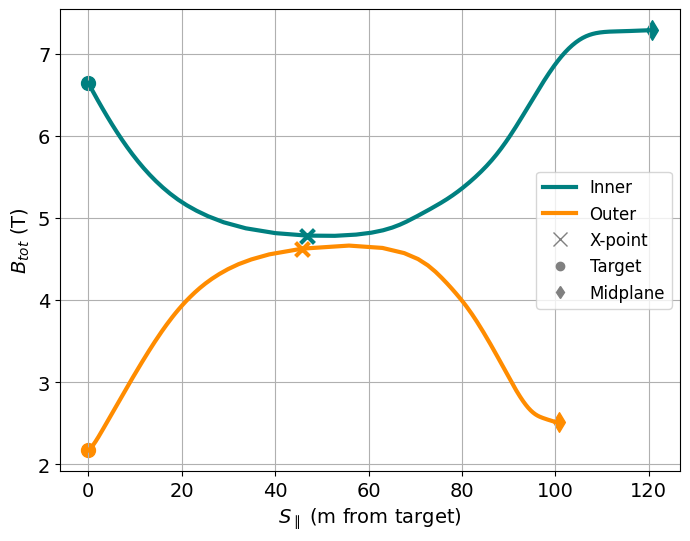

In [6]:
fig, ax = plt.subplots()
colors = mike_cmap(2)
labels = {"ou":"Outer", "iu":"Inner"}
size = 100

for i, side in enumerate(["iu", "ou"]):
    d = data[side]
    Xpoint = d["Xpoint"]
    ax.plot(d["S"], d["Btot"], color = colors[i], label = labels[side])
    ax.scatter(d["S"][Xpoint], d["Btot"][Xpoint], color = colors[i], marker = "x", s = size)
    ax.scatter(d["S"][0], d["Btot"][0], color = colors[i], marker = "o", s = size)
    ax.scatter(d["S"][-1], d["Btot"][-1], color = colors[i], marker = "d", s = size)

ax.set_xlabel("$S_{\parallel}$ (m from target)")
ax.set_ylabel("$B_{tot}$ (T)")
ax.legend()

h,l = ax.get_legend_handles_labels()
extra_handles = [
    mpl.lines.Line2D([0], [0], color = "grey", marker = "x", linewidth=0, label = "X-point", markersize = 10),
    mpl.lines.Line2D([0], [0], color = "grey", marker = "o", linewidth=0, label = "Target"),
    mpl.lines.Line2D([0], [0], color = "grey", marker = "d", linewidth=0, label = "Midplane")]

ax.legend(fontsize = 12, handles = h+extra_handles)

# Make new topologies

In [8]:
plt.close("all")
%matplotlib inline

In [20]:
points[:,1]

array([ 4.93749117e-01,  3.17408669e-01, -3.32072442e-06])

In [14]:
plt.close("all")
%matplotlib inline

In [16]:
points = np.array([[R[X], Z[X]],
                [R[10], Z[10]],
                [R[0], Z[0]]])

x = points[:,0]
y = points[:,1]

In [19]:
x

array([2.40349024, 2.02520827, 1.73506428])

## Make endpoint profile

In [263]:
d = eqb["SPR45"][side]
d_inner = eqb["SPR45"]["iu"]
d_outer = eqb["SPR45"]["ou"]

R = d_inner["R"]
Z = d_inner["Z"] * -1
X = d_inner["Xpoint"]

# R, Z are up to and including X-point
R_leg = R[:X+1]
Z_leg = Z[:X+1]


In [208]:
%matplotlib inline

In [365]:
d = eqb["SPR45"]["iu"]
morph = Morph(d["R"], d["Z"]*-1, d["Xpoint"], d["Btot"], d["Bpol"], d["S"], d["Spol"])
morph.set_start_profile(
    [
    {"pos" : 1, "offset": 0},
    {"pos" : 0.97, "offset": 0},
    {"pos" : 0.95, "offset": 0},
    {"pos" : 0.85, "offset": 0},
    {"pos" : 0.7, "offset": 0},
    {"pos" : 0.35, "offset": 0},
    {"pos" : 0.02, "offset": 0},
    {"pos" : 0.0, "offset": 0},
    ]
)

morph.set_end_profile(
    [
    {"pos" : 1, "offset": 0},
    {"pos" : 0.97, "offset": 0},
    {"pos" : 0.95, "offset": 0},
    {"pos" : 0.85, "offset": 0},
    {"pos" : 0.7, "offset": 0},
    {"pos" : 0.35, "offset": -0.2},
    {"pos" : 0.02, "offset": -1.5},
    {"pos" : 0.0, "offset": -1.98},
    ]
)

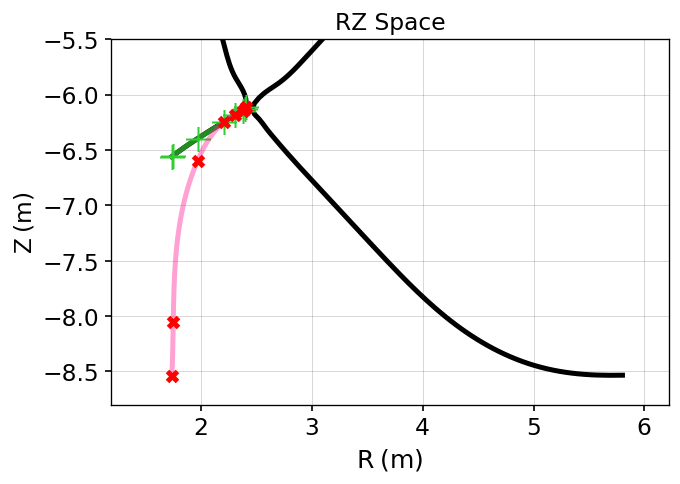

In [366]:
plt.close("all")


fig, ax = plt.subplots(1, figsize = (6,12))

ax.plot(morph.start["xs"], morph.start["ys"], c = "forestgreen", zorder = 100, alpha = 1)
ax.scatter(morph.start["x"], morph.start["y"], c = "limegreen", zorder = 100, marker = "+", linewidth = 15, s = 3)
ax.plot(morph.end["xs"], morph.end["ys"], c = "deeppink", zorder = 100, alpha = 0.4)
ax.scatter(morph.end["x"], morph.end["y"], c = "red", zorder = 100, marker = "x")

ax.plot(R_inner, Z_inner, linewidth = 3, marker = "o", markersize = 0, color = "black", alpha = 1)
ax.plot(d_outer["R"], d_outer["Z"]*-1, linewidth = 3, marker = "o", markersize = 0, color = "black", alpha = 1)
ax.set_xlabel("$R\ (m)$", fontsize = 15)
ax.set_ylabel("$Z\ (m)$")
ax.set_ylim(-8.8, -5.5)
# ax.set_xlim(1.55, 2.7)

alpha = 0.5
ax.set_title("RZ Space")
ax.grid(alpha = 0.3, color = "k")
ax.set_aspect("equal")

## Interpolate between

In [231]:
x_interp = x_start + (x_end - x_start)*0.5
y_interp = y_start + (y_end - y_start)*0.5

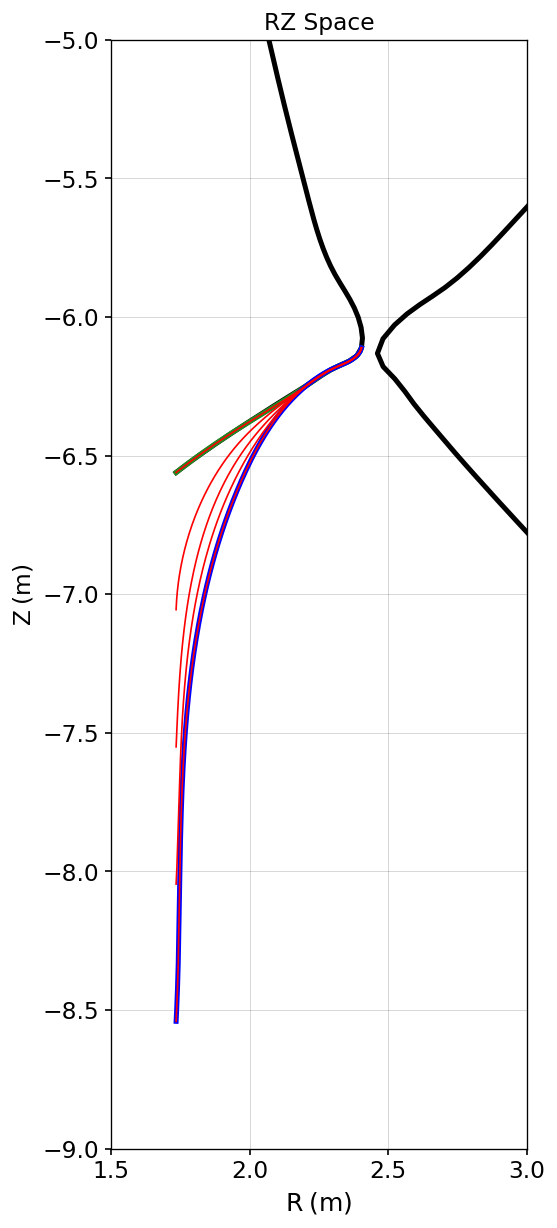

In [273]:
fig, ax = plt.subplots(1, figsize = (6,12))

prof = morph.morph_between(0.5)
ax.plot(xs_start, ys_start, c = "forestgreen", zorder = 100, alpha = 1)
ax.plot(xs_end, ys_end, c = "blue", zorder = 100, alpha = 1)

for i in np.linspace(0,1,5):
    prof = morph.morph_between(i)
    ax.plot(prof["xs"], prof["ys"], c = "red", zorder = 100, alpha = 1.0, lw = 1)

ax.plot(R_inner, Z_inner, linewidth = 3, marker = "o", markersize = 0, color = "black", alpha = 1)
ax.plot(d_outer["R"], d_outer["Z"]*-1, linewidth = 3, marker = "o", markersize = 0, color = "black", alpha = 1)
ax.set_xlabel("$R\ (m)$", fontsize = 15)
ax.set_ylabel("$Z\ (m)$")
ax.set_ylim(-9, -5)
ax.set_xlim(1.5,3)

alpha = 0.5
ax.set_title("RZ Space")

ax.grid(alpha = 0.3, color = "k")
ax.set_aspect("equal")

## Get eqb right

In [334]:
d = eqb["SPR45"]["iu"]
self = Morph(d["R"], d["Z"]*-1, d["Xpoint"], d["Btot"], d["Bpol"], d["S"], d["Spol"])
self.set_start_profile(
    [
    {"pos" : 1, "offset": 0},
    {"pos" : 0.97, "offset": 0},
    {"pos" : 0.95, "offset": 0},
    {"pos" : 0.85, "offset": 0},
    {"pos" : 0.7, "offset": 0},
    {"pos" : 0.35, "offset": 0},
    {"pos" : 0.02, "offset": 0},
    {"pos" : 0.0, "offset": 0},
    ]
)

self.set_end_profile(
    [
    {"pos" : 1, "offset": 0},
    {"pos" : 0.97, "offset": 0},
    {"pos" : 0.95, "offset": 0},
    {"pos" : 0.85, "offset": 0},
    {"pos" : 0.7, "offset": 0},
    {"pos" : 0.35, "offset": -0.2},
    {"pos" : 0.02, "offset": -1.5},
    {"pos" : 0.0, "offset": -1.98},
    ]
)

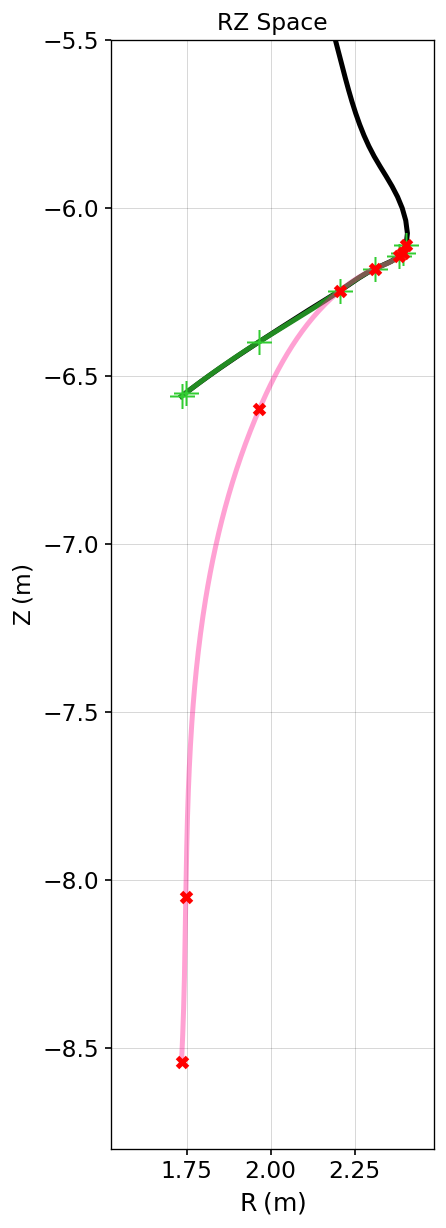

In [335]:
self.plot_profile(self.end)

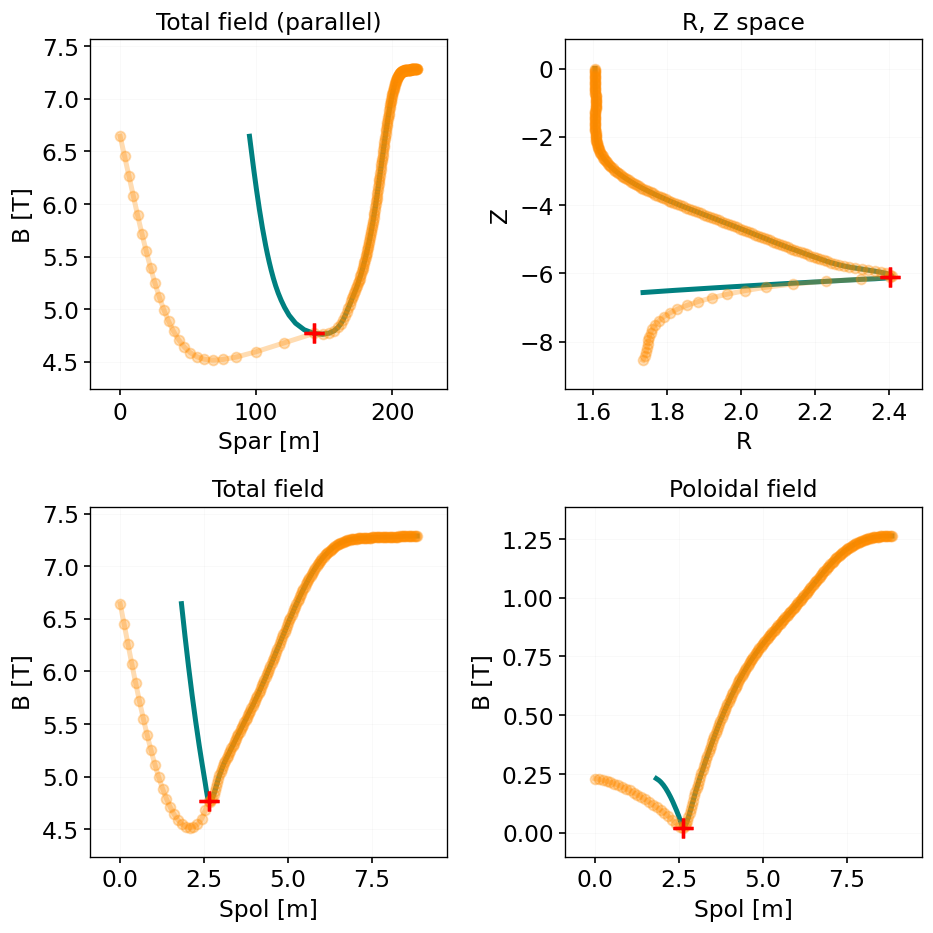

In [394]:
end = self.populate_profile(self.end)
self.plot_profile_check(end)